# Data Clustering analysis 

Find a way to cluster the UCEC data samples based on their driver/non-driver gene labels, using the signtaure exposures. 

In [1]:
import numpy as np
import pandas as pd

#add libraries and graph settings
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

In [3]:
## Read file
df_allsamp = pd.read_csv("data/samples_UCEC_sig_labels.csv")
# df_allsamp.drop(columns=["Unnamed: 0.1", 'Unnamed: 0'])
df_allsamp

Hugo_Symbol          Tumor_Sample_Barcode               HGVSp  \
0            EPHA2  TCGA-2E-A9G8-01A-11D-A403-09         p.Gly620Arg   
1           ZNF436  TCGA-2E-A9G8-01A-11D-A403-09  p.Ser202PhefsTer23   
2             MECR  TCGA-2E-A9G8-01A-11D-A403-09         p.Leu307His   
3            USP24  TCGA-2E-A9G8-01A-11D-A403-09         p.Val908Ala   
4            IL23R  TCGA-2E-A9G8-01A-11D-A403-09         p.Trp265Ter   
...            ...                           ...                 ...   
501078      MAP7D3  TCGA-SL-A6JA-01A-11D-A31U-09         p.Gln191Lys   
501079      MAGEC1  TCGA-SL-A6JA-01A-11D-A31U-09  p.Glu572ArgfsTer58   
501080        PNCK  TCGA-SL-A6JA-01A-11D-A31U-09  p.Phe212SerfsTer14   
501081        FLNA  TCGA-SL-A6JA-01A-11D-A31U-09        p.Val1830Met   
501082     SLC10A3  TCGA-SL-A6JA-01A-11D-A31U-09         p.Val318Met   

       HGVSp_Short    MSI             label  COSMICv3-SBS1  COSMICv3-SBS10a  \
0            G620R    MSS         Passenger       0.116184              NaN   
1       S202Ffs*23    MSS               NaN       0.116184              NaN   
2            L307H    MSS  Potential driver       0.116184              NaN   
3            V908A    MSS         Passenger       0.116184              NaN   
4            W265*    MSS         Passenger       0.116184              NaN   
...            ...    ...               ...            ...              ...   
501078       Q191K  MSI-H  Potential driver       0.141195         0.006316   
501079  E572Rfs*58  MSI-H               NaN       0.141195         0.006316   
501080  F212Sfs*14  MSI-H               NaN       0.141195         0.006316   
501081      V1830M  MSI-H         Passenger       0.141195         0.006316   
501082       V318M  MSI-H         Passenger       0.141195         0.006316   

        COSMICv3-SBS10b  COSMICv3-SBS11  ...  COSMICv3-SBS8  COSMICv3-SBS84  \
0                   NaN             NaN  ...            NaN             NaN   
1                   NaN             NaN  ...            NaN             NaN   
2                   NaN             NaN  ...            NaN             NaN   
3                   NaN             NaN  ...            NaN             NaN   
4                   NaN             NaN  ...            NaN             NaN   
...                 ...             ...  ...            ...             ...   
501078              NaN             NaN  ...            NaN        0.005468   
501079              NaN             NaN  ...            NaN        0.005468   
501080              NaN             NaN  ...            NaN        0.005468   
501081              NaN             NaN  ...            NaN        0.005468   
501082              NaN             NaN  ...            NaN        0.005468   

        COSMICv3-SBS85  COSMICv3-SBS9  ExpPOLEDriverLabel  \
0                  NaN            NaN         No mutation   
1                  NaN            NaN         No mutation   
2                  NaN            NaN         No mutation   
3                  NaN            NaN         No mutation   
4                  NaN            NaN         No mutation   
...                ...            ...                 ...   
501078             NaN            NaN         No mutation   
501079             NaN            NaN         No mutation   
501080             NaN            NaN         No mutation   
501081             NaN            NaN         No mutation   
501082             NaN            NaN         No mutation   

        ExpPOLD1DriverLabel  PredPOLEDriverLabel  PredPOLD1DriverLabel  \
0               No mutation          No mutation           No mutation   
1               No mutation          No mutation           No mutation   
2               No mutation          No mutation           No mutation   
3               No mutation          No mutation           No mutation   
4               No mutation          No mutation           No mutation   
...                     ...                  ...                   

In [6]:
# df_allsamp = pd.read_csv("samples_UCEC_sig_labels.csv")
filter_col = ["Tumor_Sample_Barcode", "Hugo_Symbol"] + [col for col in df_allsamp if col.startswith('COSMICv3')] + ["POLEDriverMSIStatus", "ExpPOLEDriverLabel"]
df = df_allsamp[filter_col]

# Treat Nan as 0 for signature columns 
sig_cols = [col for col in df_allsamp if col.startswith('COSMICv3')]
df[sig_cols] = df[sig_cols].fillna(0)

In [7]:
df['ExpPOLEDriverLabel'].unique()

array(['No mutation', 'Driver', 'Non driver'], dtype=object)

In [20]:
# replacing categorical driver/nondriver to numerical (representing each output cluster)
df['ExpPOLEDriverLabel'].replace(['No mutation', 'Passenger', 'Potential Driver', 'Driver'], [0, 1, 2, 3], inplace=True)

In [8]:
# df_POLE = df[df['Hugo_Symbol']=="POLE"].reset_index(drop=True)
# df_POLE = df_POLE[df_POLE['ExpPOLEDriverLabel'] != "No mutation"]

In [14]:
from sklearn import manifold

def project_signature_distribution(df, label, perplexity): 
    df_test = df.reset_index(drop=True)

    tSNE_embedding = manifold.TSNE(
        n_components=2,
        init="random",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
        perplexity=perplexity, 
    )

    sig_cols = [col for col in df_test.columns if 'COSMIC' in col]
    data = df_test.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
    y = data[label].to_numpy()
    y = np.array(['missing' if x is np.nan else x for x in y])
    data = data[sig_cols]
    data = np.nan_to_num(data.to_numpy())
    # print(data)
    # print(y)

    projection = tSNE_embedding.fit_transform(data, y)
    
    return projection, y

(529, 2)


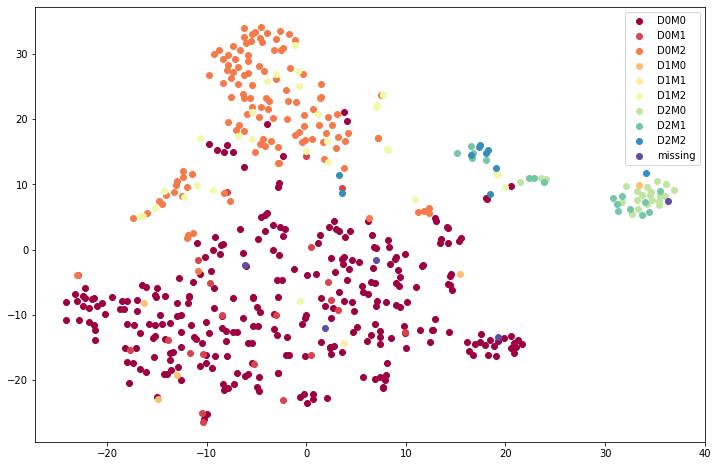

In [15]:
# Graph tSNE projection 

projection, y = project_signature_distribution(df, 'POLEDriverMSIStatus', 20)

def graph_projection(projection, labels): 
    print(projection.shape)
    unique_labels = np.unique(labels)
    plt.figure(figsize=(12,8))
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for i,lab in enumerate(unique_labels):
        index_lab = labels == lab
        # c = np.array([[float(i+1)/float(len(labs)), 0.6, float(len(labs)-i)/float(len(labs)), 1.0],])
        plt.scatter(projection[index_lab, 0], projection[index_lab, 1], color=colors[i], label=lab)
    plt.legend()

graph_projection(projection, y)

## K-Mean Clustering 

In [9]:
projection, y = project_signature_distribution(df, 'ExpPOLEDriverLabel', 20)

X = projection

from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=3)
Kmean.fit(X)

KMeans(n_clusters=3)

(529, 2)


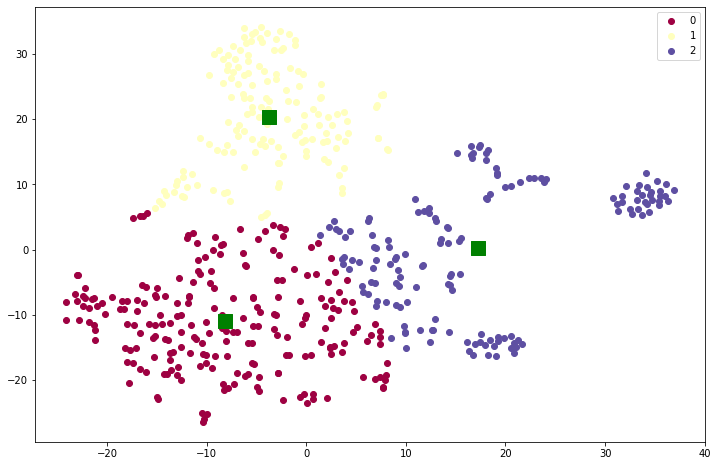

In [10]:
graph_projection(projection, Kmean.labels_)
for c in Kmean.cluster_centers_: 
    plt.scatter(c[0], c[1], s=200, c='g', marker='s')
plt.show()

## Hierarchical Clustering (Agglomerative clustering)

In [11]:
from sklearn.cluster import AgglomerativeClustering

agglo_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
agglo_clustering.fit(X)

AgglomerativeClustering(n_clusters=3)

(529, 2)


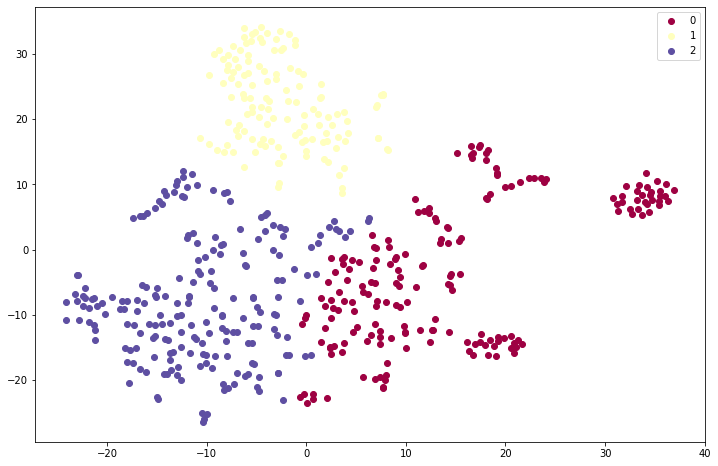

In [12]:
graph_projection(projection, agglo_clustering.labels_)

In [13]:
from sklearn.cluster import AffinityPropagation

# define the model
model = AffinityPropagation(damping=0.6)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = np.unique(yhat)
# create scatter plot for samples from each cluster
plt.figure(figsize=(12,8))
# for cluster in clusters:
# 	# get row indexes for samples with this cluster
# 	row_ix = np.where(yhat == cluster)
# 	# create scatter of these samples
# 	plt.scatter(X[row_ix, 0], X[row_ix, 1])
# # show the plot
# plt.show()

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [77]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=4, min_samples=5).fit(X)
labels = clustering.labels_
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [15]:
from sklearn import metrics

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 4
Estimated number of noise points: 4
Silhouette Coefficient: 0.207


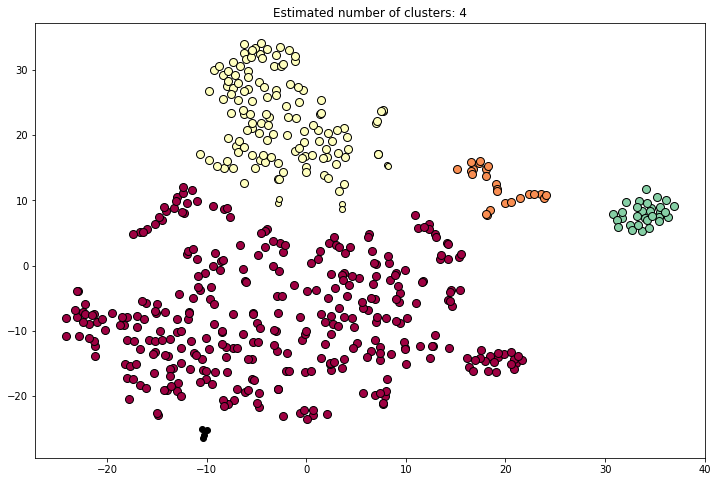

In [16]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(12,8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=8,
    )
    
    # plot out
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()


To-do: 
- Reading about each clustering methods. 
- Read about tSNE fine-tuning OR high-dimensional data clustering. 
- More into DBSCAN methods. 

# Multidimensional clustering 

Evaluation metrics 
1. Silhouette Coefficient: The Silhouette Coefficient is defined for each sample and is composed of two scores: 
    a: The mean distance between a sample and all other points in the same cluster.
    b: The mean distance between a sample and all other points in the next nearest cluster.
    
    ![image info](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/10/Image9-6.png)
    
- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around 0 indicate overlapping clusters. 
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

2. Rand index: Given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the (adjusted or unadjusted) Rand index is a function that measures the similarity of the two assignments, ignoring permutations. 
- Perfect labelling = 1.0 
- Poorly agreeing labels (e.g. independent labelings) have lower scores, and for the adjusted Rand index the score will be negative or close to zero.

3. Davis-Bouldin Index: If the ground truth labels are not known, the Davies-Bouldin index (sklearn.metrics.davies_bouldin_score) can be used to evaluate the model, where a lower Davies-Bouldin index relates to a model with better separation between the clusters. This index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.
- Zero is the lowest possible score. Values closer to zero indicate a better partition.

In [17]:
projection, y = project_signature_distribution(df, 'ExpPOLEDriverLabel', 20)

sig_cols = [col for col in df_allsamp if col.startswith('COSMICv3')]
df_x = df.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
df_x = df_x[sig_cols]
X = np.array(df_x)

## Centroid based clustering

(529, 2)


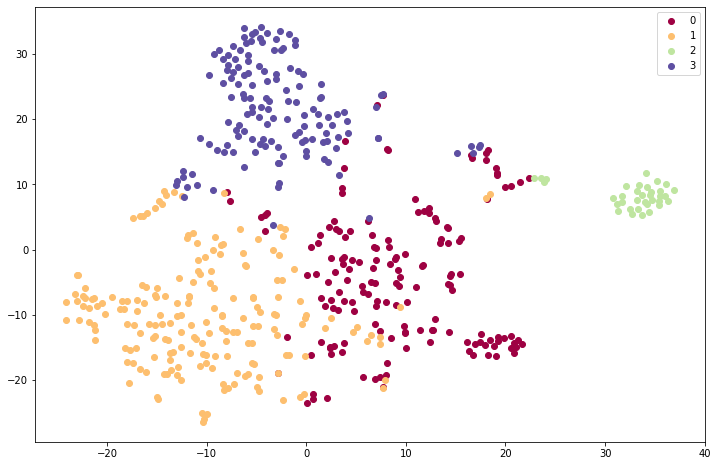

In [18]:
# K-mean clustering on multi-dim data 
Kmean = KMeans(n_clusters=4)
labels = Kmean.fit_predict(X)

graph_projection(projection, Kmean.labels_)
# for c in Kmean.cluster_centers_: 
#     plt.scatter(c[0], c[1], s=200, c='g', marker='s')
# plt.show()

In [19]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Silhouette Coefficient: 0.289


## Density-based clustering

In [78]:
# DBSCAN 
DBSCAN_clustering = DBSCAN(eps=0.2, min_samples=5).fit(X)
labels = DBSCAN_clustering.labels_
core_samples_mask = np.zeros_like(DBSCAN_clustering.labels_, dtype=bool)
core_samples_mask[DBSCAN_clustering.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [21]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("Davis-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(X, labels))
print("Rand Index: %0.3f" % metrics.rand_score(y, labels))

Estimated number of clusters: 4
Estimated number of noise points: 97
Silhouette Coefficient: 0.070
Davis-Bouldin Index: 2.329
Rand Index: 0.702


In [22]:
metrics.cluster.pair_confusion_matrix(y, labels)

array([[ 59408,  20414],
       [ 62942, 136548]])

(529, 2)


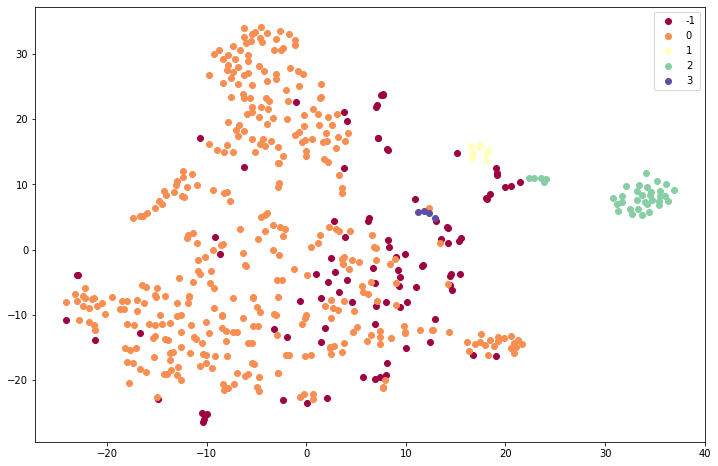

In [23]:
graph_projection(projection, labels) 

In [24]:
# OPTICS 
from sklearn.cluster import OPTICS
OPTICS_clust = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05).fit(X)
labels = OPTICS_clust.labels_

In [25]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("Davis-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(X, labels))
print("Rand Index: %0.3f" % metrics.rand_score(y, labels))

Silhouette Coefficient: 0.278
Davis-Bouldin Index: 1.029
Rand Index: 0.640


(529, 2)


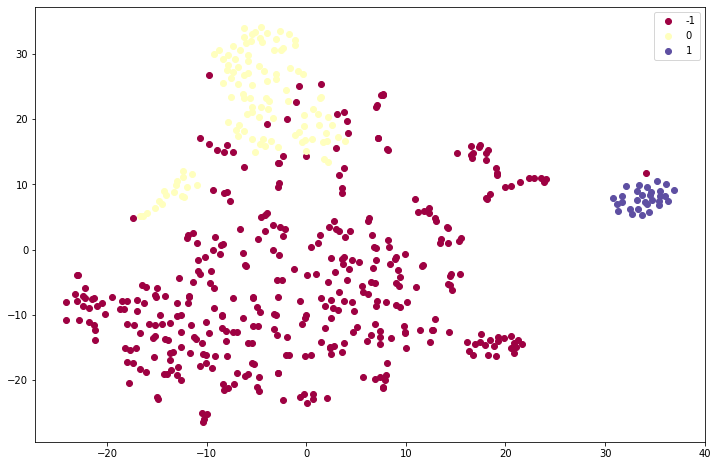

In [26]:
graph_projection(projection, labels) 

## Hierarchical Clustering

In [27]:
agglo_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels = agglo_clustering.fit(X).labels_

(529, 2)


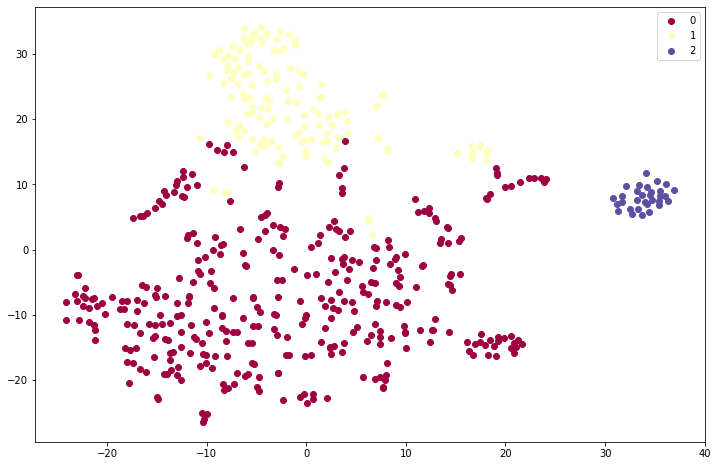

In [28]:
graph_projection(projection, labels) 

In [29]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("Davis-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(X, labels))
print("Rand Index: %0.3f" % metrics.rand_score(y, labels))

Silhouette Coefficient: 0.320
Davis-Bouldin Index: 1.008
Rand Index: 0.649


## Graph-based clustering

In [63]:
from sklearn.cluster import SpectralClustering
spectral_clust = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0).fit(X)
labels = spectral_clust.labels_

(529, 2)


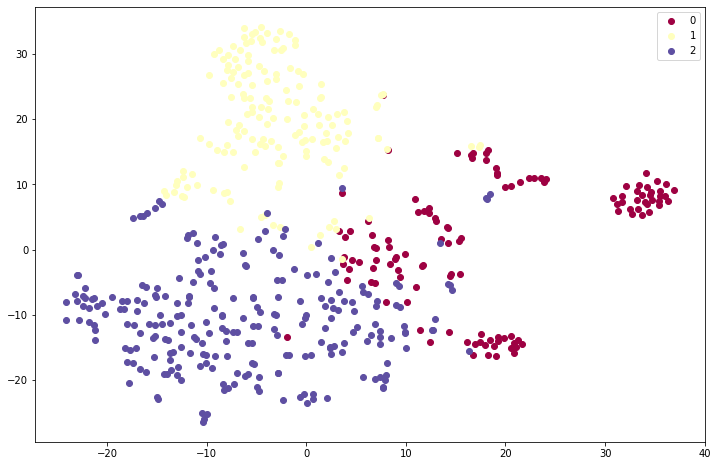

In [31]:
graph_projection(projection, labels) 

In [32]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("Davis-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(X, labels))
print("Rand Index: %0.3f" % metrics.rand_score(y, labels))

Silhouette Coefficient: 0.301
Davis-Bouldin Index: 1.582
Rand Index: 0.511


In [33]:
## With selected signatures 
# sig_selected = ['COSMICv3-SBS20', 'COSMICv3-SBS10b', 'COSMICv3-SBS6',
#        'COSMICv3-SBS10a', 'COSMICv3-SBS42', 'COSMICv3-SBS54',
#        'COSMICv3-SBS23', 'COSMICv3-SBS15', 'COSMICv3-SBS13',
#        'COSMICv3-SBS14']
# sig_selected = ['COSMICv3-SBS10a', 'COSMICv3-SBS10b', 'COSMICv3-SBS20',
#        'COSMICv3-SBS15', 'COSMICv3-SBS14', 'COSMICv3-SBS54',
#        'COSMICv3-SBS6', 'COSMICv3-SBS1', 'COSMICv3-SBS49',
#        'COSMICv3-SBS17a']
# sig_selected = ['COSMICv3-SBS10b', 'COSMICv3-SBS20', 'COSMICv3-SBS54',
#        'COSMICv3-SBS49', 'COSMICv3-SBS10a', 'COSMICv3-SBS17b',
#        'COSMICv3-SBS42', 'COSMICv3-SBS17a', 'COSMICv3-SBS23',
#        'COSMICv3-SBS6']
sig_selected = ['COSMICv3-SBS10a', 'COSMICv3-SBS10b', 'COSMICv3-SBS20',
       'COSMICv3-SBS54', 'COSMICv3-SBS6']
projection, y = project_signature_distribution(df, 'ExpPOLEDriverLabel', 20)

df_x = df.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
df_x = df_x[sig_selected]
X = np.array(df_x)

In [34]:
spectral_clust = SpectralClustering(n_clusters=3, assign_labels='discretize', random_state=0).fit(X)
labels = spectral_clust.labels_

(529, 2)


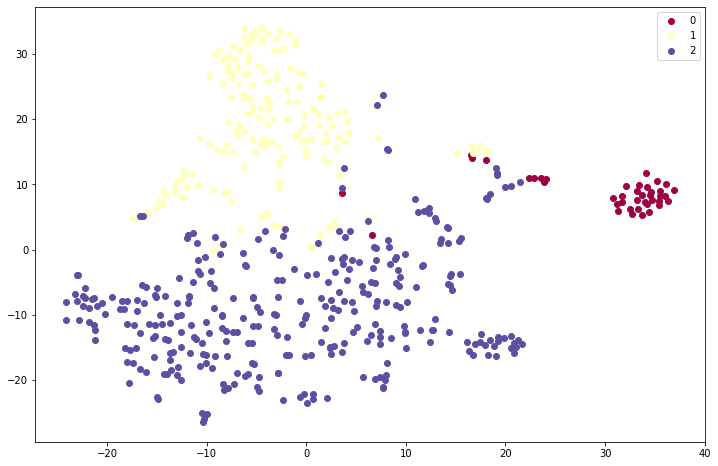

In [35]:
graph_projection(projection, labels) 

In [36]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("Davis-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(X, labels))
print("Rand Index: %0.3f" % metrics.rand_score(y, labels)) 

Silhouette Coefficient: 0.618
Davis-Bouldin Index: 0.541
Rand Index: 0.617


- Combine MSI status into outcome. 
- Kucab signatures -> ask Alex 
    - Check if there are sigs related to POLE and POLD1 or non-known processes. 
    - alexander.goncearenco@gmail.com
- Classification 

# tSNE Projection on 3D graph

In [16]:
from sklearn import manifold

def project_signature_distribution_3D(df, label, perplexity): 
    df_test = df.reset_index(drop=True)

    tSNE_embedding = manifold.TSNE(
        n_components=3,
        init="random",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
        perplexity=perplexity, 
    )

    sig_cols = [col for col in df_test.columns if 'COSMIC' in col]
    data = df_test.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
    y = data[label].to_numpy()
    y = np.array(['missing' if x is np.nan else x for x in y])
    data = data[sig_cols]
    data = np.nan_to_num(data.to_numpy())
    # print(data)
    # print(y)

    projection = tSNE_embedding.fit_transform(data, y)
    
    return projection, y

In [18]:
projection, y = project_signature_distribution_3D(df, 'POLEDriverMSIStatus', 20)

In [19]:
projection.shape

(529, 3)

In [20]:
labels = y

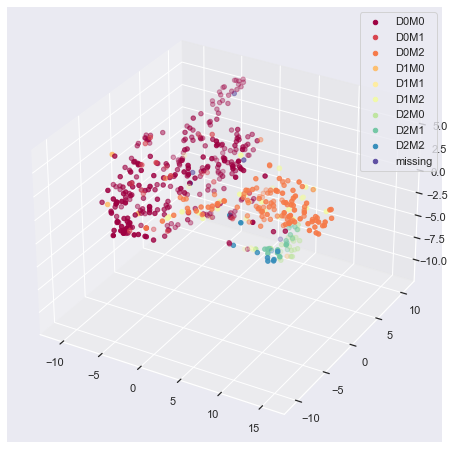

In [21]:
sns.set(style = "darkgrid")
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection = '3d')

unique_labels = np.unique(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for i,lab in enumerate(unique_labels):
    index_lab = labels == lab
    # c = np.array([[float(i+1)/float(len(labs)), 0.6, float(len(labs)-i)/float(len(labs)), 1.0],])
    ax.scatter(projection[index_lab, 0], projection[index_lab, 1], projection[index_lab, 2], color=colors[i], label=lab)
plt.legend()


In [22]:
import plotly
import plotly.express as px
import plotly.graph_objs as go
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

d = {"x": projection[:,0], "y": projection[:,1], "z":projection[:,2], "labels":y}
df_graph = pd.DataFrame(d)
fig = px.scatter_3d(df_graph, x="x", y="y", z="z", color="labels", size_max=2, opacity=0.8)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Clustering by MSI-Driver status combined flag

In [23]:
filter_col = ["Tumor_Sample_Barcode", "Hugo_Symbol"] + [col for col in df_allsamp if col.startswith('COSMICv3')] + ["POLEDriverMSIStatus"]
df = df_allsamp[filter_col]

# Treat Nan as 0 for signature columns 
sig_cols = [col for col in df_allsamp if col.startswith('COSMICv3')]
df[sig_cols] = df[sig_cols].fillna(0)

/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Pairwise combined Driver status and MSI status
- D = ['No mutation', 'Non driver', 'Driver'] = [0, 1, 2]
- M = ['MSS', 'MSI-L', 'MSI-H', 'nan] = [0, 1, 2, 3]

(529, 2)


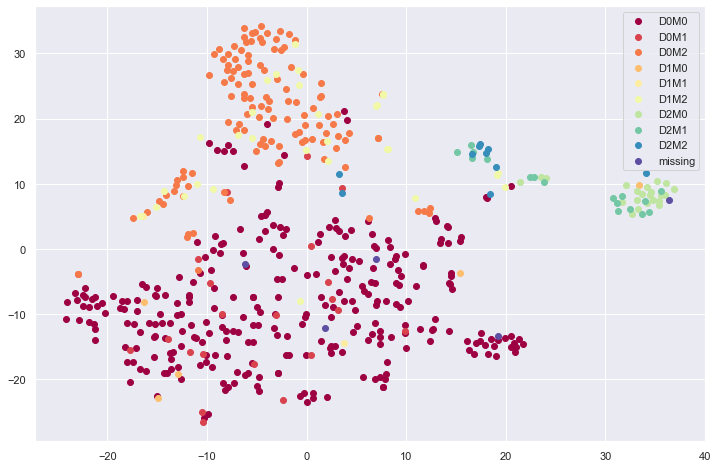

In [24]:
projection, y = project_signature_distribution(df, 'POLEDriverMSIStatus', 20)

graph_projection(projection, y)

In [25]:
projection, y = project_signature_distribution_3D(df, 'POLEDriverMSIStatus', 20)

d = {"x": projection[:,0], "y": projection[:,1], "z":projection[:,2], "labels":y}
df_graph = pd.DataFrame(d)
fig = px.scatter_3d(df_graph, x="x", y="y", z="z", color="labels", size_max=2, opacity=0.8)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [26]:
## Combine some tags for better visualization 
# 1. Combine M0,1,3 (MSS, MSI-L and Nan to ML (low))
df['POLEDriverMSIStatus'].replace(['D0M0', 'D0M1', 'D0M3', 'D1M0', 'D1M1', 'D1M3', 'D2M0', 'D2M1', 'D2M3'], ['D0ML', 'D0ML', 'D0ML', 'D1ML', 'D1ML', 'D1ML', 'D2ML', 'D2ML', 'D2ML'], inplace=True)

/Users/jessysong/miniforge3/envs/env_mutagene/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
df['POLEDriverMSIStatus'].unique()

array(['D0ML', 'D2M2', 'D2ML', 'D0M2', 'D1M2', 'D1ML', nan], dtype=object)

In [27]:
projection, y = project_signature_distribution_3D(df, 'POLEDriverMSIStatus', 20)

d = {"x": projection[:,0], "y": projection[:,1], "z":projection[:,2], "labels":y}
df_graph = pd.DataFrame(d)
fig = px.scatter_3d(df_graph, x="x", y="y", z="z", color="labels", size_max=2, opacity=0.8, width=1200, height=800)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

- Insert Plotly to a Powerpoint: https://evidencen.com/how-to-embed-plotly-graphs-in-powerpoint/ 

In [36]:
df_filt = df[~df['POLEDriverMSIStatus'].isnull()]

projection, y = project_signature_distribution_3D(df_filt, 'POLEDriverMSIStatus', 20)

d = {"x": projection[:,0], "y": projection[:,1], "z":projection[:,2], "labels":y}
df_graph = pd.DataFrame(d)
fig = px.scatter_3d(df_graph, x="x", y="y", z="z", color="labels", size_max=2, opacity=0.8, width=1200, height=800)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [28]:
## Export graph for powerpoint 
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls 

username = "JessySong"
api_key = 'XRMMtCHABC2euULBhchG'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [37]:
py.plot(fig, filename="3D tSNE visualization", auto_open=False)

'https://plotly.com/~JessySong/1/'

(524, 2)


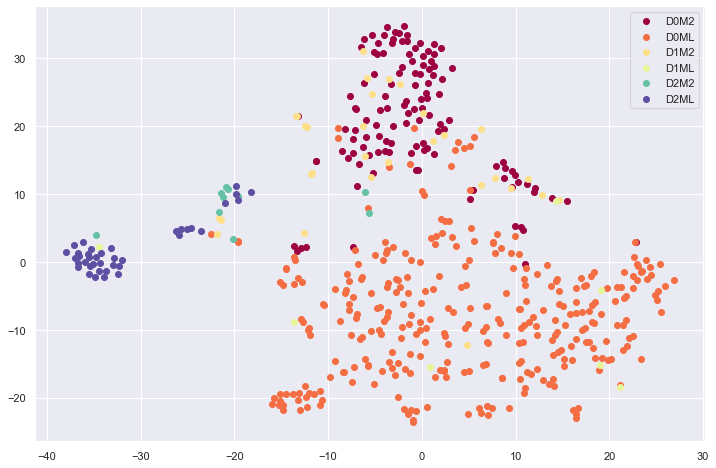

In [38]:
projection, y = project_signature_distribution(df_filt, 'POLEDriverMSIStatus', 20)
graph_projection(projection, y)

## Conduct Projection on Selected features

In [58]:
# Selected features based on outcome = combined Driver-MSI outcomes (10 cases)
# # Univariate method: 
# sig_selected = ['COSMICv3-SBS10b', 'COSMICv3-SBS10a', 'COSMICv3-SBS6',
#        'COSMICv3-SBS13', 'COSMICv3-SBS20', 'COSMICv3-SBS2',
#        'COSMICv3-SBS14', 'COSMICv3-SBS28', 'COSMICv3-SBS1',
#        'COSMICv3-SBS54'] #13 and 2 do not occur in other

# # ExtraTreesClassifier method: 
# sig_selected = ['COSMICv3-SBS10b', 'COSMICv3-SBS10a', 'COSMICv3-SBS14',
#        'COSMICv3-SBS15', 'COSMICv3-SBS28', 'COSMICv3-SBS6',
#        'COSMICv3-SBS1', 'COSMICv3-SBS54', 'COSMICv3-SBS7b',
#        'COSMICv3-SBS20'] #7b and 15 do not occur in other
# # Correlation matrix 
# sig_selected = ['COSMICv3-SBS49', 'COSMICv3-SBS54', 'COSMICv3-SBS14',
#        'COSMICv3-SBS10b', 'COSMICv3-SBS20', 'COSMICv3-SBS53',
#        'COSMICv3-SBS6', 'COSMICv3-SBS17b', 'COSMICv3-SBS10a',
#        'COSMICv3-SBS22'] #49, 53, 17b, do not occur in other
# Common features: 
sig_selected = ['COSMICv3-SBS10a', 'COSMICv3-SBS10b', 'COSMICv3-SBS14',
       'COSMICv3-SBS20', 'COSMICv3-SBS54', 'COSMICv3-SBS6'] ## -> maybe not enough, calculate the classification accuracy for each feature sets 

cols = ["Tumor_Sample_Barcode", "POLEDriverMSIStatus"]+ sig_selected

# df_x = df.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
df_x = df[cols]
# X = np.array(df_x)
projection, y = project_signature_distribution_3D(df_x, 'POLEDriverMSIStatus', 20)

In [59]:
d = {"x": projection[:,0], "y": projection[:,1], "z":projection[:,2], "labels":y}
df_graph = pd.DataFrame(d)
fig = px.scatter_3d(df_graph, x="x", y="y", z="z", color="labels", size_max=2, opacity=0.8, width=800, height=800)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

check the specific POLEs mutation of the 2 driver clusters. 

(529, 2)


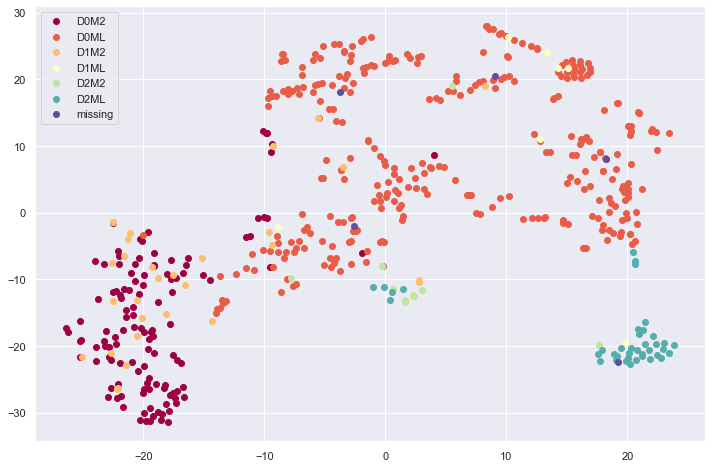

In [60]:
projection, y = project_signature_distribution(df_x, 'POLEDriverMSIStatus', 20)
graph_projection(projection, y) 

## Clustering on pairwise labels + filtered features

In [43]:
df_x = df_filt.drop_duplicates(["Tumor_Sample_Barcode"]) 

# sig_selected defined in above. 
df_x = df_x[sig_cols]
X = np.array(df_x)

In [44]:
# density-based clustering 
from sklearn.cluster import DBSCAN
DBSCAN_clustering = DBSCAN(eps=0.09, min_samples=1).fit(X)
labels = DBSCAN_clustering.labels_
core_samples_mask = np.zeros_like(DBSCAN_clustering.labels_, dtype=bool)
core_samples_mask[DBSCAN_clustering.core_sample_indices_] = True
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [46]:
# graph_projection(projection, labels) 

In [98]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("Davis-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(X, labels))
print("Rand Index: %0.3f" % metrics.rand_score(y, labels))

Silhouette Coefficient: -0.187
Davis-Bouldin Index: 0.727
Rand Index: 0.594


In [52]:
# spatial clustering 
from sklearn.cluster import SpectralClustering
spectral_clust = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0).fit(X)
labels = spectral_clust.labels_

(524, 2)


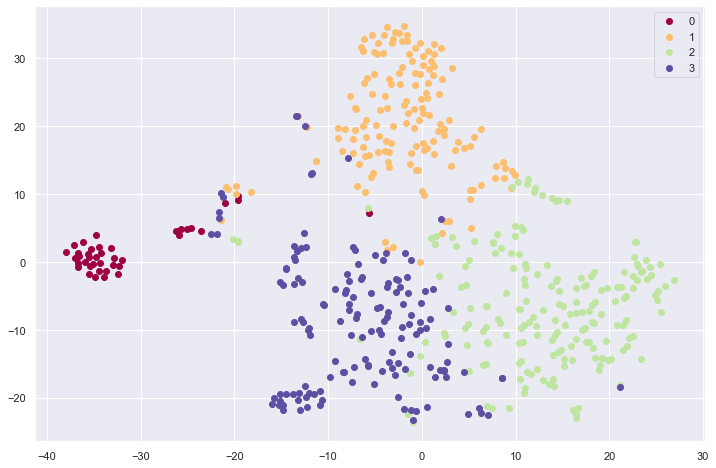

In [53]:
graph_projection(projection, labels) 

In [54]:
from sklearn import metrics

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))
print("Davis-Bouldin Index: %0.3f" % metrics.davies_bouldin_score(X, labels))
print("Rand Index: %0.3f" % metrics.rand_score(y, labels))

Silhouette Coefficient: 0.283
Davis-Bouldin Index: 1.418
Rand Index: 0.694


- Predicted POLE from mutagene in 3D 
- Classification using signatures
    - 356 data of POLE driver + no mutation - binary classification 
- ++ colorectal data 

In [56]:
data = df.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
data

Tumor_Sample_Barcode Hugo_Symbol  COSMICv3-SBS1  \
0       TCGA-2E-A9G8-01A-11D-A403-09       EPHA2       0.116184   
52      TCGA-4E-A92E-01A-11D-A37N-09      ARID1A       0.061179   
188     TCGA-5B-A90C-01A-11D-A37N-09       INTS3       0.188141   
228     TCGA-5S-A9Q8-01A-11D-A403-09      ARID1A       0.384341   
276     TCGA-A5-A0G1-01A-11D-A122-09      SCNN1D       0.029416   
...                              ...         ...            ...   
498993  TCGA-QS-A8F1-01A-21D-A37N-09      ARID4B       0.252204   
499045  TCGA-SJ-A6ZI-01A-12D-A34Q-09      TTLL10       0.245330   
500288  TCGA-SJ-A6ZJ-01A-12D-A34Q-09      FBLIM1       0.366069   
500341  TCGA-SL-A6J9-01A-11D-A31U-09       EPB41       0.204633   
500383  TCGA-SL-A6JA-01A-11D-A31U-09       ISG15       0.141195   

        COSMICv3-SBS10a  COSMICv3-SBS10b  COSMICv3-SBS11  COSMICv3-SBS12  \
0              0.000000         0.000000        0.000000         0.03632   
52             0.000000         0.110138        0.000000         0.00000   
188            0.022797         0.000000        0.000000         0.00000   
228            0.000000         0.110800        0.000000         0.00000   
276            0.024778         0.047005        0.000000         0.00000   
...                 ...              ...             ...             ...   
498993         0.000000         0.000000        0.015914         0.00000   
499045         0.000000         0.023789        0.000000         0.00000   
500288         0.012012         0.000000        0.000000         0.00000   
500341         0.000000         0.000000        0.000000         0.00000   
500383         0.006316         0.000000        0.000000         0.00000   

        COSMICv3-SBS13  COSMICv3-SBS14  COSMICv3-SBS15  ...  COSMICv3-SBS60  \
0             0.008932        0.000000        0.000000  ...             0.0   
52            0.241207        0.000000        0.000000  ...             0.0   
188           0.000000        0.050412        0.000000  ...             0.0   
228           0.000000        0.000000        0.000000  ...             0.0   
276           0.000000        0.276352        0.097427  ...             0.0   
...                ...             ...             ...  ...             ...   
498993        0.056323        0.000000        0.000000  ...             0.0   
499045        0.000000        0.024367        0.213594  ...             0.0   
500288        0.000000        0.000000        0.000000  ...             0.0   
500341        0.000000        0.000000        0.000000  ...             0.0   
500383        0.000000        0.000000        0.079427  ...             0.0   

        COSMICv3-SBS7a  COSMICv3-SBS7b  COSMICv3-SBS7c  COSMICv3-SBS7d  \
0             0.020479        0.000000        0.000000        0.000000   
52            0.053155        0.000000        0.000000        0.009760   
188           0.000000        0.044976        0.000000        0.000000   
228           0.000000        0.000000        0.000000        0.000000   
276           0.000000        0.077767        0.015403        0.004242   
...                ...             ...             ...             ...   
498993        0.053189        0.046589        0.000000        0.000000   
499045        0.000000        0.000000        0.000000        0.000000   
500288        0.068519        0.005553        0.000000        0.000000   
500341        0.000000        0.000000        0.000000        0.046728   
500383        0.009693        0.000000        0.000000        0.000000   

        COSMICv3-SBS8  COSMICv3-SBS84  COSMICv3-SBS85  COSMICv3-SBS9  \
0                 0.0        0.000000             0.0            0.0   
52                0.0        0.000000             0.0            0.0   
188               0.0        0.000000             0.0            0.0   
228               0.0        0.000000             0.0            0.0   
276               0.0        0.000000             0.0            0.0   
...               ...       

In [57]:
df_allsamp = pd.read_csv("samples_UCEC_sig_labels.csv")

In [58]:
df_allsamp

Hugo_Symbol          Tumor_Sample_Barcode               HGVSp  \
0            EPHA2  TCGA-2E-A9G8-01A-11D-A403-09         p.Gly620Arg   
1           ZNF436  TCGA-2E-A9G8-01A-11D-A403-09  p.Ser202PhefsTer23   
2             MECR  TCGA-2E-A9G8-01A-11D-A403-09         p.Leu307His   
3            USP24  TCGA-2E-A9G8-01A-11D-A403-09         p.Val908Ala   
4            IL23R  TCGA-2E-A9G8-01A-11D-A403-09         p.Trp265Ter   
...            ...                           ...                 ...   
501078      MAP7D3  TCGA-SL-A6JA-01A-11D-A31U-09         p.Gln191Lys   
501079      MAGEC1  TCGA-SL-A6JA-01A-11D-A31U-09  p.Glu572ArgfsTer58   
501080        PNCK  TCGA-SL-A6JA-01A-11D-A31U-09  p.Phe212SerfsTer14   
501081        FLNA  TCGA-SL-A6JA-01A-11D-A31U-09        p.Val1830Met   
501082     SLC10A3  TCGA-SL-A6JA-01A-11D-A31U-09         p.Val318Met   

       HGVSp_Short    MSI             label  COSMICv3-SBS1  COSMICv3-SBS10a  \
0            G620R    MSS         Passenger       0.116184              NaN   
1       S202Ffs*23    MSS               NaN       0.116184              NaN   
2            L307H    MSS  Potential driver       0.116184              NaN   
3            V908A    MSS         Passenger       0.116184              NaN   
4            W265*    MSS         Passenger       0.116184              NaN   
...            ...    ...               ...            ...              ...   
501078       Q191K  MSI-H  Potential driver       0.141195         0.006316   
501079  E572Rfs*58  MSI-H               NaN       0.141195         0.006316   
501080  F212Sfs*14  MSI-H               NaN       0.141195         0.006316   
501081      V1830M  MSI-H         Passenger       0.141195         0.006316   
501082       V318M  MSI-H         Passenger       0.141195         0.006316   

        COSMICv3-SBS10b  COSMICv3-SBS11  ...  COSMICv3-SBS7d  COSMICv3-SBS8  \
0                   NaN             NaN  ...             NaN            NaN   
1                   NaN             NaN  ...             NaN            NaN   
2                   NaN             NaN  ...             NaN            NaN   
3                   NaN             NaN  ...             NaN            NaN   
4                   NaN             NaN  ...             NaN            NaN   
...                 ...             ...  ...             ...            ...   
501078              NaN             NaN  ...             NaN            NaN   
501079              NaN             NaN  ...             NaN            NaN   
501080              NaN             NaN  ...             NaN            NaN   
501081              NaN             NaN  ...             NaN            NaN   
501082              NaN             NaN  ...             NaN            NaN   

        COSMICv3-SBS84  COSMICv3-SBS85  COSMICv3-SBS9  ExpPOLEDriverLabel  \
0                  NaN             NaN            NaN         No mutation   
1                  NaN             NaN            NaN         No mutation   
2                  NaN             NaN            NaN         No mutation   
3                  NaN             NaN            NaN         No mutation   
4                  NaN             NaN            NaN         No mutation   
...                ...             ...            ...                 ...   
501078        0.005468             NaN            NaN         No mutation   
501079        0.005468             NaN            NaN         No mutation   
501080        0.005468             NaN            NaN         No mutation   
501081        0.005468             NaN            NaN         No mutation   
501082        0.005468             NaN            NaN         No mutation   

        ExpPOLD1DriverLabel  PredPOLEDriverLabel  PredPOLD1DriverLabel  \
0               No mutation          No mutation           No mutation   
1               No mutation          No mutation           No mutation   
2               No mutation          No mutation           No mutation   
3               No muta

In [60]:
filter_col = ["Tumor_Sample_Barcode", "Hugo_Symbol"] + [col for col in df_allsamp if col.startswith('COSMICv3')] + ["ExpPOLEDriverLabel"]
df = df_allsamp[filter_col]
data = df.drop_duplicates(subset=["Tumor_Sample_Barcode"]) 
data[data['ExpPOLEDriverLabel']=="Driver"]

Tumor_Sample_Barcode Hugo_Symbol  COSMICv3-SBS1  \
276     TCGA-A5-A0G1-01A-11D-A122-09      SCNN1D       0.029416   
9029    TCGA-A5-A0G2-01A-11W-A062-09       NOC2L       0.118908   
35413   TCGA-A5-A0GP-01A-11W-A062-09        NOL9       0.064454   
39164   TCGA-A5-A1OF-01A-11D-A14G-09       NOC2L       0.074075   
50302   TCGA-A5-A2K5-01A-11D-A17W-09      SAMD11       0.043802   
65051   TCGA-AJ-A3EK-01A-11D-A19Y-09       NOC2L       0.074665   
70386   TCGA-AJ-A3EL-01A-11D-A20S-09       PERM1       0.062094   
80017   TCGA-AJ-A5DW-01A-11D-A27P-09      ATAD3A       0.047904   
84483   TCGA-AP-A051-01A-21W-A027-09      TTLL10       0.121726   
93171   TCGA-AP-A056-01A-11W-A027-09       NOC2L       0.065261   
100998  TCGA-AP-A059-01A-21D-A122-09       NOC2L       0.051223   
113361  TCGA-AP-A0LM-01A-11D-A122-09     PLEKHN1       0.160276   
138557  TCGA-AP-A1DV-01A-21D-A135-09       OR4F5       0.052324   
150019  TCGA-AP-A1E0-01A-11D-A135-09       NOC2L       0.056520   
155923  TCGA-AX-A05Z-01A-11W-A027-09       NOC2L       0.053492   
163686  TCGA-AX-A06F-01A-11W-A027-09      ATAD3B       0.031984   
171389  TCGA-AX-A0J0-01A-11D-A117-09      ATAD3B       0.048629   
199045  TCGA-AX-A2HC-01A-11D-A17D-09       OR4F5       0.091646   
238633  TCGA-B5-A11E-01A-11D-A10M-09        AGRN       0.076871   
249230  TCGA-B5-A11N-01A-11D-A122-09        CHD5       0.079899   
263902  TCGA-B5-A3FA-01A-11D-A19Y-09    C1orf159       0.003035   
272892  TCGA-B5-A3FC-01A-11D-A228-09      SAMD11       0.328738   
288493  TCGA-BG-A0VX-01A-11D-A122-09      SAMD11       0.144884   
297893  TCGA-BK-A6W3-01A-12D-A34Q-09      UBE2J2       0.043352   
301890  TCGA-BS-A0TC-01A-11D-A10B-09        ESPN       0.072231   
305015  TCGA-BS-A0UF-01A-11D-A10B-09     PLEKHN1       0.045663   
315247  TCGA-BS-A0UV-01A-11D-A10B-09      SAMD11       0.091478   
326030  TCGA-D1-A103-01A-11D-A10M-09      ATAD3C       0.155546   
337768  TCGA-D1-A16X-01A-11D-A12J-09      ACTRT2       0.067775   
339892  TCGA-D1-A16Y-01A-31D-A12J-09      CFAP74       0.095447   
344861  TCGA-D1-A17Q-01A-11D-A12J-09       NOC2L       0.070945   
358246  TCGA-DF-A2KU-01A-11D-A17W-09      KLHL17       0.019440   
367760  TCGA-DF-A2KV-01A-11D-A17W-09       NOC2L       0.041879   
377625  TCGA-E6-A1LX-01A-11D-A14G-09      TTLL10       0.052272   
389397  TCGA-E6-A1M0-01A-11D-A142-09      ZBTB48       0.030421   
394282  TCGA-EO-A22R-01A-11D-A18P-09       OR4F5       0.107983   
408036  TCGA-EO-A22U-01A-11D-A17W-09       NOC2L       0.211887   
421210  TCGA-EO-A22X-01A-11D-A17W-09      SAMD11       0.042699   
431134  TCGA-EO-A3AV-01A-12D-A19Y-09       CCNL2       0.033352   
434987  TCGA-EO-A3AY-01A-12D-A19Y-09        CPTP       0.035279   
439085  TCGA-EO-A3B0-01A-12D-A19Y-09       NOC2L       0.023292   
452198  TCGA-EY-A1G8-01A-11D-A13L-09       NOC2L       0.061045   
454597  TCGA-EY-A1GD-01A-11D-A13L-09       NBPF1       0.063165   
456016  TCGA-EY-A1GI-01A-11D-A13L-09       NOC2L       0.042501   
463929  TCGA-EY-A215-01A-11D-A14K-09      KLHL17       0.092491   
472481  TCGA-FI-A2D0-01A-11D-A17D-09      SAMD11       0.237886   
479017  TCGA-FI-A2D5-01A-11D-A17D-09       NOC2L       0.040336   
496357  TCGA-QF-A5YS-01A-11D-A31U-09       NOC2L       0.068491   
497821  TCGA-QS-A5YQ-01A-11D-A31U-09    SLC25A33       0.062576   

        COSMICv3-SBS10a  COSMICv3-SBS10b  COSMICv3-SBS11  COSMICv3-SBS12  \
276            0.024778         0.047005             NaN             NaN   
9029           0.054860         0.133506        0.009164             NaN   
35413          0.245889         0.414160             NaN             NaN   
39164          0.022570         0.027631        0.021924             NaN   
50302          0.316946         0.359411             NaN             NaN   
65051          0.100694         0.104747        0.049763             NaN   
70386          0.204251         0.383479             NaN             NaN   
80017          0.391298         0.366830             NaN 